In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

In [2]:
import os
import datetime
import math

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

from src.utils.fileutils import get_project_root
from src.data.annotations import load_dataset_annotations
from src.data.annotations import make_continious_labels, dense_to_events, single_track_labels
from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
from src.data.annotations import class_color_map

from src.data.annotations import load_noise_classes


In [3]:
project_root = get_project_root()

In [59]:
spectrograms = pandas.read_parquet(os.path.join(project_root, 'data/processed/spectrograms/logmels-64bands-256hop.parquet')).droplevel(0).sort_index(level=(0, 1))
spectrograms.columns = [ float(c) for c in spectrograms.columns ]
spectrograms = spectrograms.droplevel(0)
spectrograms.head(3)


50.0       97.0       144.0      191.0   \
clip   time                                                                 
File-1 0 days 00:00:00         76.366348  63.375744  69.915855  72.795792   
       0 days 00:00:00.016000  86.127220  81.912064  81.125793  79.113632   
       0 days 00:00:00.032000  88.637444  83.462677  80.319939  70.542473   

                                  238.0      285.0      333.0      380.0   \
clip   time                                                                 
File-1 0 days 00:00:00         70.675804  64.539680  64.628601  64.500427   
       0 days 00:00:00.016000  70.817024  69.234024  66.322372  63.199497   
       0 days 00:00:00.032000  70.271698  71.657135  69.789192  63.858154   

                                  427.0      474.0   ...     5168.0  \
clip   time                                          ...              
File-1 0 days 00:00:00         65.665695  63.571503  ...  44.144093   
       0 days 00:00:00.016000  71.627029  72.095154  ...  44.421707   
       0 days 00:00:00.032000  73.646713  75.614471  ...  38.644417   

                                  5425.0     5695.0     5978.0     6275.0  \
clip   time                                                                 
File-1 0 days 00:00:00         41.016563  39.719444  38.927895  38.644417   
       0 days 00:00:00.016000  44.814396  43.257744  38.644417  38.644417   
       0 days 00:00:00.032000  39.325253  41.800926  38.644417  38.644417   

                                  6588.0     6916.0     7260.0     7621.0  \
clip   time                                                                 
File-1 0 days 00:00:00         38.644417  38.644417  38.644417  38.644417   
       0 days 00:00:00.016000  38.644417  38.644417  38.644417  38.644417   
       0 days 00:00:00.032000  38.644417  38.644417  38.644417  38.644417   

                                  8000.0  
clip   time                               
File-1 0 days 00:00:00         38.644417  
       0 days 00:00:00.016000  38.644417  
       0 days 00:00:00.032000  38.644417  

[3 rows x 64 columns]

In [8]:
from src.sed.train import load_data_tracks, prepare_tracks

embeddings, annotations = load_data_tracks()

embeddings.shape


skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping TUT_annotation_notes.md
skipping File-3.wav
skipping File-2.wav
skipping File-1.wav


(45450, 1024)

In [83]:
window_length = 65
windows = prepare_tracks(embeddings, annotations, window_length=window_length)

windows.head()

features  \
clip   window                                                                      
File-1 0 days 00:00:00         [[0.0, 0.09498539566993713, 0.0, 0.00196724128...   
       0 days 00:00:31.200000  [[0.022443005815148354, 0.0, 0.0, 0.0170332994...   
       0 days 00:01:02.400000  [[0.04239673539996147, 0.007057905197143555, 0...   
       0 days 00:01:33.600000  [[0.07597961276769638, 0.08016347140073776, 0....   
       0 days 00:02:04.800000  [[0.014708657748997211, 0.013508130796253681, ...   

                                                                          labels  \
clip   window                                                                      
File-1 0 days 00:00:00         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
       0 days 00:00:31.200000  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
       0 days 00:01:02.400000  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
       0 days 00:01:33.600000  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
       0 days 00:02:04.800000  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                               music     other  road_traffic    speech  
clip   window                                                           
File-1 0 days 00:00:00           0.0  0.292308      0.138462  0.200000  
       0 days 00:00:31.200000    0.0  0.138462      0.430769  0.015385  
       0 days 00:01:02.400000    0.0  0.030769      0.492308  0.000000  
       0 days 00:01:33.600000    0.0  0.046154      0.446154  0.000000  
       0 days 00:02:04.800000    0.0  0.169231      0.061538  0.076923

In [84]:
windows.groupby('clip').mean().round(2)[['music', 'speech', 'road_traffic', 'other']]

,music,speech,road_traffic,other
clip,,,,
File-1,0.01,0.08,0.35,0.12
File-2,0.00,0.12,0.58,0.05
File-3,0.00,0.32,0.31,0.08


0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72
0.0 30.72


0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

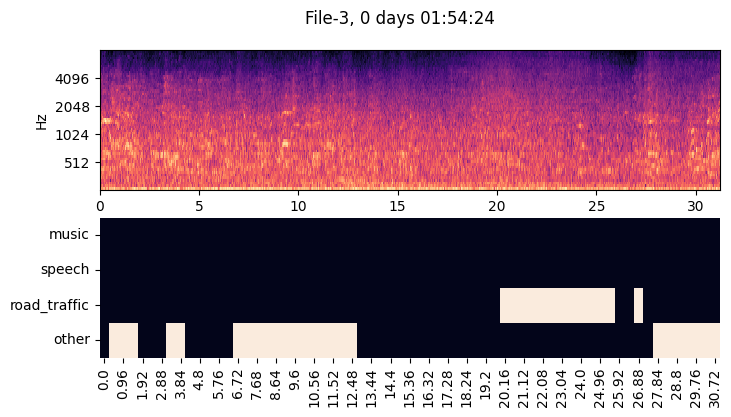

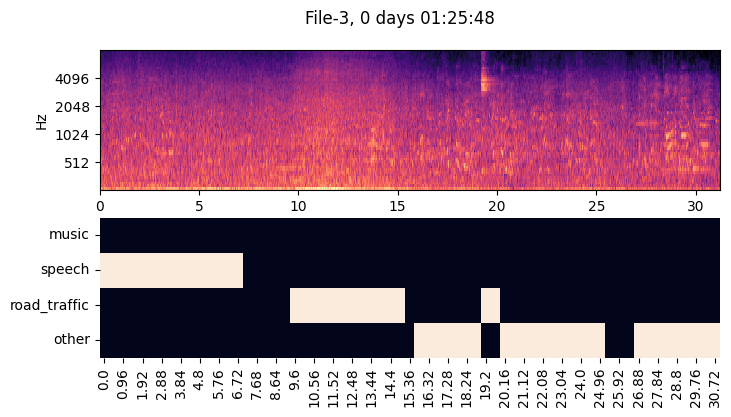

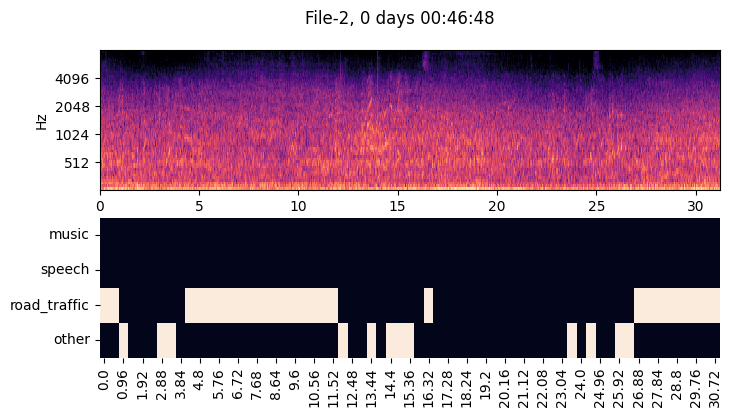

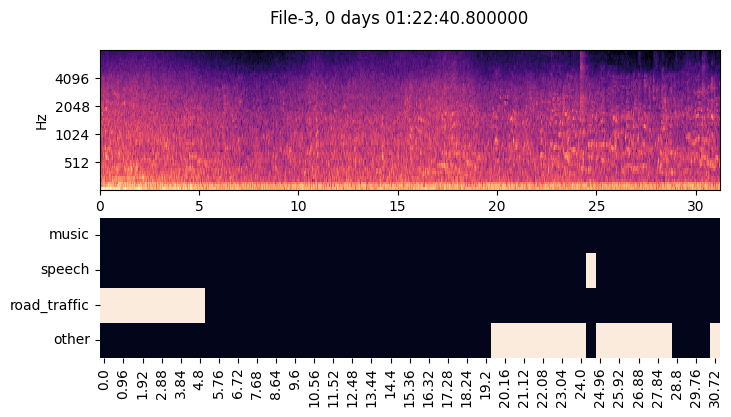

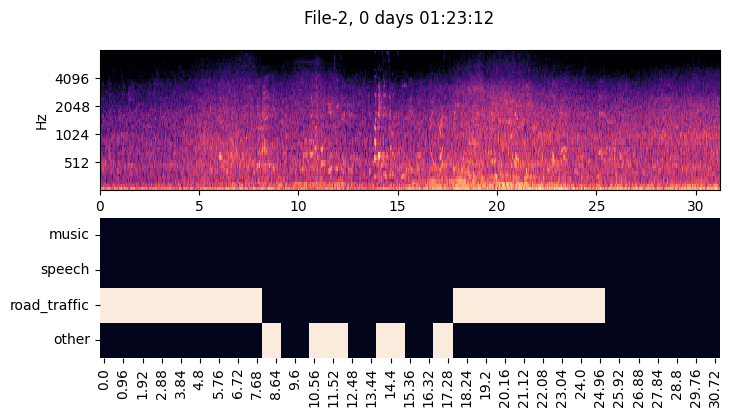

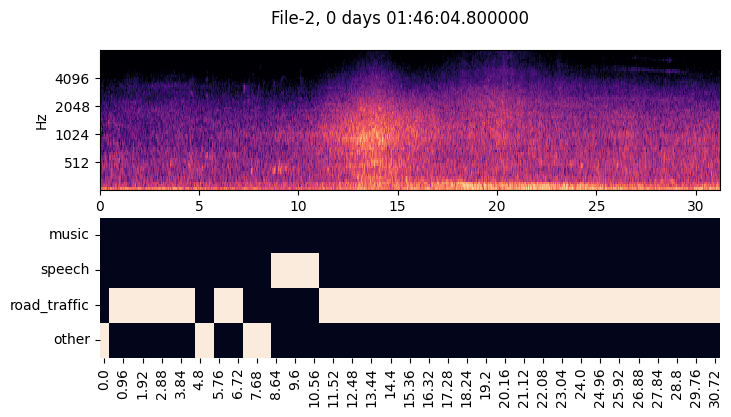

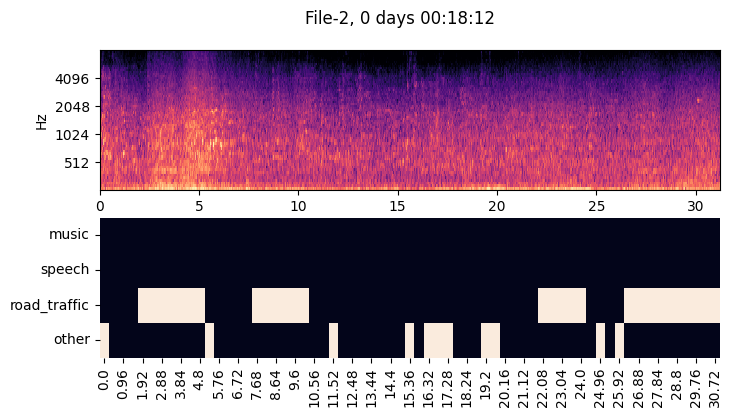

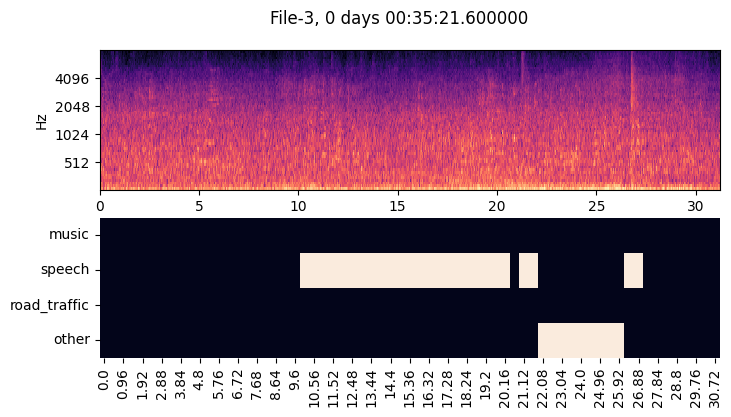

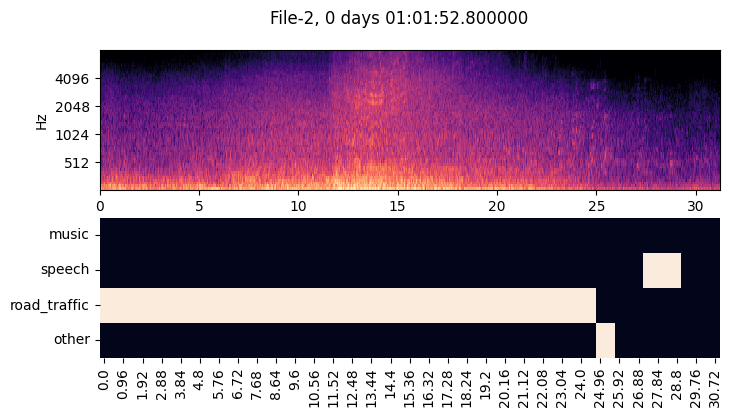

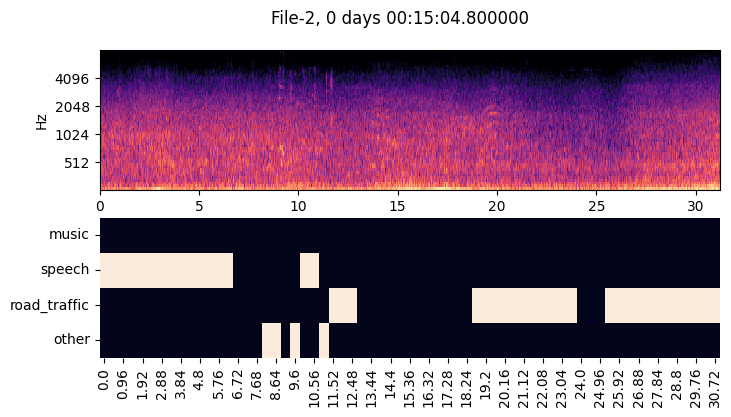

In [86]:

from src.data.annotations import clip_events
from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
from src.features.spectrogram import plot_spectrogram
from src.data.annotations import class_color_map

def plot_window(window):
    hop_duration = 0.48
    
    clip_idx = window['clip']
    start = window['window']
    #print(clip_idx)
    
    end = start + pandas.Timedelta(seconds=hop_duration)*window_length
    #l = soundlevels.loc[idx].loc[start:end]
    s = spectrograms.loc[clip_idx].loc[start:end]
    e = annotations.loc[clip_idx].copy()
    e = clip_events(e, start=start/pandas.Timedelta(seconds=1), end=end/pandas.Timedelta(seconds=1))

    #print(s.head())
    fig, (spec_ax, label_ax) = plt.subplots(2, figsize=(8, 4), sharex=False)

    times = numpy.round((numpy.arange(0, window_length) * hop_duration), 2)
    print(times.min(), times.max())
    classes = ['music', 'speech', 'road_traffic', 'other']
    act = pandas.DataFrame(window['labels'].T, columns=classes, index=times)
    #print(act.shape)

    seaborn.heatmap(act.T, ax=label_ax, cbar=False)
    
    plot_spectrogram(spec_ax, s)
    title = f'{clip_idx}, {start}'
    fig.suptitle(title)

sel = windows.sample(n=10, random_state=1)
#sel
sel.reset_index().apply(plot_window, axis=1)



In [6]:

def plot_clip(levels, spec, ann, title='',
              enable_soundlevel_summary=False,
              soundlevel_summary=['L10', 'L90', 'Leq'],
              soundlevel_summary_colors={'L10': 'red', 'Leq': 'orange', 'L90': 'green'},
              height = 4.0,
              aspect = 4.0,
             ):

    from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
    from src.features.spectrogram import plot_spectrogram
    from src.data.annotations import class_color_map
    
    width = aspect * height
    fig, (spec_ax, level_ax, label_ax) = plt.subplots(3, figsize=(width, height), sharex=True)

    # spectrogram
    if spec is not None:
        plot_spectrogram(spec_ax, spec)
    
    # soundlevels
    if levels is not None:
        from src.features.soundlevel import compute_background
        ll = compute_background(levels.level, window=30.0)
        ll = ll.reset_index()
        ll['time'] = ll['time'] / pandas.Timedelta(seconds=1)
        seaborn.lineplot(ax=level_ax, data=ll, y='level', x='time')
        #seaborn.lineplot(ax=level_ax, data=ll, y='background', x='time')

    if enable_soundlevel_summary:
        for metric in soundlevel_summary:
            metric_level = compute_metric(levels, metric)
            color = soundlevel_summary_colors.get(metric, 'gray')
            level_ax.axhline(metric_level, ls='--', alpha=0.5, color=color, label=metric)

        level_ax.legend()
    
    # annotations
    classes=all_classes
    time_resolution=0.100

    if ann is not None:
        ann['noise_class'] = ann.annotation.map(m.noise.to_dict()).fillna('unknown')
        last = ann['end'].max()
        multi = make_continious_labels(ann, length=math.ceil(last/time_resolution),
                                     time_resolution=time_resolution,
                                     class_column='noise_class',
                                     classes=classes)
    
        single = single_track_labels(multi)
        #seaborn.lineplot(ax=label_ax, data=ll, y='delta', x='time', color='red')
        label_ax.axhline(0.0, ls='-', alpha=0.5)
        label_ax.axhline(5.0, ls='--', alpha=0.5)
        label_ax.axhline(10.0, ls='--', alpha=0.5)
        plot_single_track_labels(label_ax, single, colors=class_color_map, alpha=0.5)

    if title:
        fig.suptitle(title)

    return fig

files = annotations.reset_index().set_index(['dataset', 'clip']).index.unique()
files = files.to_frame()
files = files[files.dataset == 'bcn']

def plot(row):
    # select a subset of data
    start = pandas.Timedelta(minutes=0)
    end = pandas.Timedelta(minutes=10.0)
    idx = tuple(row)
    l = soundlevels.loc[idx].loc[start:end]
    s = spectrograms.loc[idx].loc[start:end]
    e = annotations.loc[idx].copy()
    e = clip_events(e, start=start/pandas.Timedelta(seconds=1), end=end/pandas.Timedelta(seconds=1))
    e['noise_class'] = e.annotation.map(m.noise.to_dict()).fillna('unknown')

    plot_clip(l, s, e, title=f'{str(idx)}')

files.apply(plot, axis=1)


KeyError: "None of ['dataset'] are in the columns"